In [10]:
import cv2
import os
import glob
import dask


import numpy as np
import pandas as pd
import dask.array as da

from matplotlib import pyplot as plt
from dask_ml.decomposition import PCA
from tqdm import tqdm_notebook

%matplotlib inline

In [11]:
wrk_dir=os.getcwd()
os.chdir(f"{wrk_dir}/data/images")
image_lst=[f"{os.getcwd()}/{file}" for file in glob.glob("*.jpeg")]
os.chdir(wrk_dir)

In [12]:
#load images in dask in a lazy way
lzy_read = dask.delayed(cv2.imread)

lzy_images = [lzy_read(path) for path in image_lst]


#get first image, assume others are same sisze
first_image = lzy_images[0].compute()

#load images into dask
image_arr = [da.from_delayed(img,
                             dtype=first_image.dtype,
                             shape=first_image.shape
                            )
             for img in lzy_images
            ]

In [13]:
def fft_image(img_name):
    img = cv2.imread(img_name,0)
    fft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    fshift = np.fft.fftshift(fft)
    mag_spec = 20*np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1]))
    # merge real and imaginary
    return np.hstack(mag_spec)

In [14]:
lzy_fft = dask.delayed(fft_image)


In [15]:
first_image = lzy_fft(image_lst[0]).compute()

In [16]:
lzy_images = [lzy_fft(image_name) for image_name in image_lst]

In [18]:
image_arr = [da.from_delayed(img,
                             dtype=first_image.dtype,
                             shape=first_image.shape
                            )
             for img in lzy_images
            ]

In [25]:
features = da.stack(image_arr, axis=0)

In [26]:
pca = PCA(n_components=2)

In [ ]:
decomp_feat = np.asarray(pca.fit_transform(features[:500]))

In [ ]:
plt.scatter(decomp_feat[:,0], decomp_feat[:,1])

In [77]:
flat_images = [da.stack(img,axis=0) for image in image_arr]

KeyboardInterrupt: 

In [ ]:
flat_images

In [59]:
arr = np.asarray(fshift.compute())


cv2.magnitude(arr[:,:,0],arr[:,:,1])

TypeError: Expected cv::UMat for argument 'x'

In [60]:
arr[:,:,1]

array([[  0.+0.j,  33.+0.j,   0.+0.j, ..., 714.+0.j, 765.+0.j, 423.+0.j],
       [ 15.+0.j,  15.+0.j,   0.+0.j, ..., 765.+0.j, 762.+0.j, 333.+0.j],
       [  0.+0.j,   0.+0.j,  39.+0.j, ..., 738.+0.j, 765.+0.j,   0.+0.j],
       ...,
       [765.+0.j, 765.+0.j, 765.+0.j, ..., 765.+0.j, 765.+0.j, 765.+0.j],
       [ 30.+0.j,   0.+0.j,  18.+0.j, ..., 765.+0.j, 708.+0.j, 765.+0.j],
       [ 24.+0.j,  30.+0.j,  18.+0.j, ..., 738.+0.j, 765.+0.j, 318.+0.j]])

In [30]:
#apply fft
for img in tqdm_notebook(image_arr[:10]):
    fft = da.fft.fft(img)
    fshift = da.fft.fftshift(fft)
    mag_spect = da.fabs([fshift[:,:,0], fshift[:,:,1]])
    

KeyboardInterrupt: 

In [29]:
fshift

dask.array<rechunk-merge, shape=(2339, 1653, 3), dtype=complex128, chunksize=(2339, 1653, 3)>

In [ ]:
plt.imshow(mag_spect)

In [96]:
feats = []
index = []
pca_ev = []

for img_name in tqdm_notebook(image_lst[:100]):
    img = cv2.imread(img_name,0)
    fft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    fshift = np.fft.fftshift(fft)

    # merge real and imaginary
    mag_spect = 20*np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1]))
    
    index.append(img_name.rsplit("/")[-1].split(".")[0])
    
    feats.append(np.ndarray.flatten(mag_spect))
    #cv2.imwrite(f"{os.getcwd()}/data/fft_images/{name}-fft.jpeg", mag_spect)

In [97]:
pca = PCA(n_components=2)
decomp_feats = pca.fit_transform(np.vstack(feats))


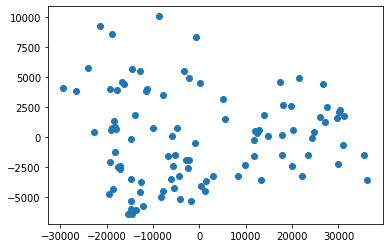

In [98]:
plt.scatter(decomp_feats[:,0], decomp_feats[:,1])

In [99]:
df = pd.DataFrame(decomp_feats, index=index)

In [100]:
df.head()

,0,1
c082c0699e75c30e9ccacb585c40a4bd6e68c7e1-page19,-15488.187500,-6394.701172
1aa81bdcdcef85cf3d9926c2a779b8e3345341f1-page217,-21523.876953,9241.127930
4b5b776dd738e13378472f8be42b478e86464812-page1,-7757.554199,3477.261230
403db5528a041970483581f52ae3df38939b5541-page6,5474.146484,1539.009033
1a92879c11dcde3665f3f96474087c1ef721b0fc-page8,-14519.727539,5669.855469


In [101]:
df.to_csv(f"{os.getcwd()}/data/processed/fft_features.csv")

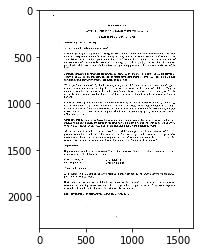

In [54]:
plt.imshow(img, cmap="gray")

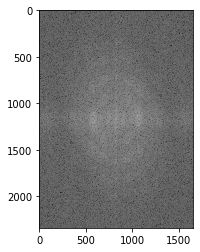

In [55]:
plt.imshow(mag_spect, cmap="gray")

array([198.46475, 201.10025, 199.67496, ..., 199.67496, 201.10025,
       198.46475], dtype=float32)